In [10]:
import torch
from model import ResNet18
from utils import *
from torch.utils.data import DataLoader
from unlearn_tech import *

In [2]:
from torchvision.datasets import CIFAR10
train_ds = CIFAR10(root='.', train=True,download=True, transform=transform_train)
valid_ds = CIFAR10(root='.', train=False,download=True, transform=transform_train)

batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=32, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=32, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
num_classes = 10
classwise_train = {}
for i in range(num_classes):
    classwise_train[i] = []

for img, label in train_ds:
    classwise_train[label].append((img, label))
    
classwise_test = {}
for i in range(num_classes):
    classwise_test[i] = []

for img, label in valid_ds:
    classwise_test[label].append((img, label))

In [5]:
# train the model
device = 'cuda'
model = ResNet18(num_classes = 10, pretrained = False).to(device)
epochs = 20
history, tr_loss, val_loss = fit_one_cycle(epochs, model, train_dl, valid_dl, device = device)
# torch.save(model.state_dict(), "ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt")

/home/bashlab/nur/test/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bashlab/nur/test/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [0], val_loss: 1.3376, val_acc: 51.6919
Epoch [1], val_loss: 0.8989, val_acc: 69.2974
Epoch [2], val_loss: 0.6876, val_acc: 75.7265
Epoch [3], val_loss: 0.8167, val_acc: 74.6318
Epoch [4], val_loss: 0.5017, val_acc: 82.7926
Epoch [5], val_loss: 0.5493, val_acc: 81.9467
Epoch [6], val_loss: 0.5190, val_acc: 83.3698
Epoch [7], val_loss: 0.5150, val_acc: 84.0366
Epoch [8], val_loss: 0.5736, val_acc: 84.2755
Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00009: reducing learning rate of group 1 to 5.0000e-03.
Epoch [9], val_loss: 0.6567, val_acc: 85.7385
Epoch [10], val_loss: 0.6932, val_acc: 85.5792
Epoch [11], val_loss: 0.7244, val_acc: 84.9323
Epoch [12], val_loss: 0.7277, val_acc: 85.0717
Epoch 00013: reducing learning rate of group 0 to 2.5000e-04.
Epoch 00013: reducing learning rate of group 1 to 2.5000e-03.
Epoch [13], val_loss: 0.8164, val_acc: 86.4152
Epoch [14], val_loss: 0.8176, val_acc: 86.1465
Epoch [15], val_loss: 0.9206, val_acc: 86.0569
Epoch [16]

In [8]:
print(val_loss)

20


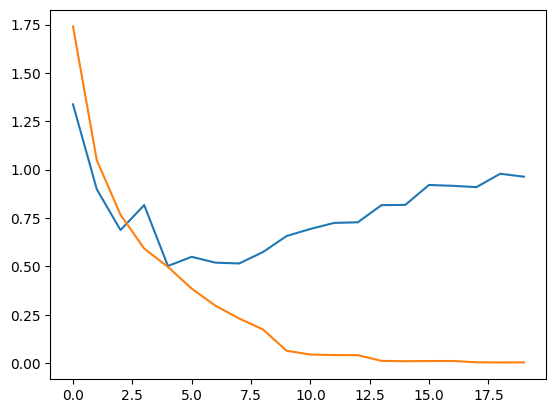

In [10]:
import matplotlib.pyplot as plt
x = range(len(tr_loss))
plt.plot(x, tr_loss)
plt.plot(x, val_loss)
plt.savefig('loss_scratch.pdf')
plt.show()

In [4]:
# load the trained model
device = 'cuda'
model = ResNet18(num_classes = 10, pretrained = True).to(device)
model.load_state_dict(torch.load("ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt", map_location='cuda'))

/home/bashlab/nur/test/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bashlab/nur/test/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [11]:
import random
forget_valid = []
all_forget_classes = [[6], [0, 6]]
for i in range(len(all_forget_classes)):
    forget_classes =  all_forget_classes[i]
    # forget_classes.append(all_forget_classes[i])
    # print(forget_classes)
    for cls in range(num_classes):
        if cls in forget_classes:
            for img, clabel in classwise_test[cls]:
                forget_valid.append((img, clabel))

    retain_valid = []
    for cls in range(num_classes):
        if cls not in forget_classes:
            for img, clabel in classwise_test[cls]:
                retain_valid.append((img, clabel))
                
    forget_train = []
    for cls in range(num_classes):
        if cls in forget_classes:
            for img, clabel in classwise_train[cls]:
                forget_train.append((img, clabel))

    retain_train = []
    for cls in range(num_classes):
        if cls not in forget_classes:
            for img, clabel in classwise_train[cls]:
                retain_train.append((img, clabel))

    forget_valid_dl = DataLoader(forget_valid, batch_size, num_workers=32, pin_memory=True)

    retain_valid_dl = DataLoader(retain_valid, batch_size, num_workers=32, pin_memory=True)

    forget_train_dl = DataLoader(forget_train, batch_size, num_workers=32, pin_memory=True)
    retain_train_dl = DataLoader(retain_train, batch_size, num_workers=32, pin_memory=True, shuffle = True)
    
    retain_train_subset = random.sample(retain_train, int(0.3*len(retain_train)))
    retain_train_subset_dl = DataLoader(retain_train_subset, batch_size, num_workers=32, pin_memory=True, shuffle = True)
    
    device = 'cuda'
    unlearning_teacher = ResNet18(num_classes = 10, pretrained = False).to(device)
    # unlearning_teacher.load_state_dict(torch.load("ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt", map_location = device))
    unlearning_teacher = unlearning_teacher.eval()
    competent_teacher = ResNet18(num_classes = 10, pretrained = False).to(device)
    competent_teacher.load_state_dict(torch.load("ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt", map_location = device))
    student_model = ResNet18(num_classes = 10, pretrained = False).to(device)
    student_model.load_state_dict(torch.load("ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt", map_location = device))
    competent_teacher = competent_teacher.eval()

    KL_temperature = 1

    optimizer = torch.optim.Adam(student_model.parameters(), lr = 0.0001)

    blindspot_unlearner(model = student_model, unlearning_teacher = unlearning_teacher, full_trained_teacher = competent_teacher, 
              retain_data = retain_train_subset, forget_data = forget_train, epochs = 5, optimizer = optimizer, lr = 0.0001, 
              batch_size = 64, num_workers = 32, device = device, KL_temperature = KL_temperature)

    print(evaluate(student_model, forget_valid_dl, device))
    print(evaluate(student_model, retain_valid_dl, device))

    # print(f'accuracy of original model on retain data, {evaluate(model, retain_valid_dl, device)}')
    # print(f'accuracy of original model on forget data, {evaluate(model, forget_valid_dl, device)}')

    # retrain_model = ResNet18(num_classes = 10, pretrained = True).to(device)
    # epochs = 5
    # history = fit_one_cycle(epochs, retrain_model, retain_train_dl, retain_valid_dl, device = device)
    # torch.save(retrain_model.state_dict(), "ResNET18_CIFAR10_scratch_retrain_Class" +str(forget_classes) +"_5_Epochs.pt")


    # device = 'cuda'
    # retrained_model = ResNet18(num_classes = 10, pretrained = False).to(device)
    # retrained_model.load_state_dict(torch.load("ResNET18_CIFAR10_scratch_retrain_Class" + str(forget_classes)+"_5_Epochs.pt", map_location=device))

    # print(evaluate(retrained_model, forget_valid_dl, device))
    # print(evaluate(retrained_model, retain_valid_dl, device))
    

Epoch 1 Unlearning Loss 0.03459922596812248
Epoch 2 Unlearning Loss 0.009592833928763866
Epoch 3 Unlearning Loss 0.007506383582949638
Epoch 4 Unlearning Loss 0.006063377019017935
Epoch 5 Unlearning Loss 0.007027400657534599
{'Loss': 2.3520326614379883, 'Acc': 0.1953125}
{'Loss': 0.31784528493881226, 'Acc': 91.32756805419922}
Epoch 1 Unlearning Loss 0.043707385659217834
Epoch 2 Unlearning Loss 0.012440772727131844
Epoch 3 Unlearning Loss 0.009613914415240288
Epoch 4 Unlearning Loss 0.007264189887791872
Epoch 5 Unlearning Loss 0.006061818916350603
{'Loss': 2.360525369644165, 'Acc': 0.06648936122655869}
{'Loss': 0.32165858149528503, 'Acc': 90.30000305175781}


In [12]:
import random
forget_valid = []
all_forget_classes = [[0], [6], [0, 6], [0, 1, 2], [4, 5, 6]]
for i in range(len(all_forget_classes)-1):
    forget_classes =  all_forget_classes[i]
    u_class = all_forget_classes[i+1]
    # forget_classes.append(all_forget_classes[i])
    # print(forget_classes)
    for cls in range(num_classes):
        if cls in forget_classes:
            for img, clabel in classwise_test[cls]:
                forget_valid.append((img, clabel))

    retain_valid = []
    for cls in range(num_classes):
        if cls not in forget_classes:
            for img, clabel in classwise_test[cls]:
                retain_valid.append((img, clabel))
                
    forget_train = []
    for cls in range(num_classes):
        if cls in forget_classes:
            for img, clabel in classwise_train[cls]:
                forget_train.append((img, clabel))

    retain_train = []
    for cls in range(num_classes):
        if cls not in forget_classes:
            for img, clabel in classwise_train[cls]:
                retain_train.append((img, clabel))

    forget_valid_dl = DataLoader(forget_valid, batch_size, num_workers=32, pin_memory=True)

    retain_valid_dl = DataLoader(retain_valid, batch_size, num_workers=32, pin_memory=True)

    forget_train_dl = DataLoader(forget_train, batch_size, num_workers=32, pin_memory=True)
    retain_train_dl = DataLoader(retain_train, batch_size, num_workers=32, pin_memory=True, shuffle = True)
    
    retain_train_subset = random.sample(retain_train, int(0.3*len(retain_train)))
    retain_train_subset_dl = DataLoader(retain_train_subset, batch_size, num_workers=32, pin_memory=True, shuffle = True)
    
    device = 'cuda'
    unlearning_teacher = ResNet18(num_classes = 10, pretrained = False).to(device)
    unlearning_teacher.load_state_dict(torch.load("ResNET18_CIFAR10_scratch_retrain_Class" + str(u_class)+"_5_Epochs.pt", map_location = device))
    unlearning_teacher = unlearning_teacher.eval()
    competent_teacher = ResNet18(num_classes = 10, pretrained = False).to(device)
    competent_teacher.load_state_dict(torch.load("ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt", map_location = device))
    student_model = ResNet18(num_classes = 10, pretrained = False).to(device)
    student_model.load_state_dict(torch.load("ResNET18_CIFAR10_Pretrained_ALL_CLASSES_5_Epochs.pt", map_location = device))
    competent_teacher = competent_teacher.eval()

    KL_temperature = 1

    optimizer = torch.optim.Adam(student_model.parameters(), lr = 0.0001)

    blindspot_unlearner(model = student_model, unlearning_teacher = unlearning_teacher, full_trained_teacher = competent_teacher, 
              retain_data = retain_train_subset, forget_data = forget_train, epochs = 5, optimizer = optimizer, lr = 0.0001, 
              batch_size = 64, num_workers = 32, device = device, KL_temperature = KL_temperature)

    print(evaluate(student_model, forget_valid_dl, device))
    print(evaluate(student_model, retain_valid_dl, device))

Epoch 1 Unlearning Loss 0.006655804812908173
Epoch 2 Unlearning Loss 0.006459160707890987
Epoch 3 Unlearning Loss 0.004891122691333294
Epoch 4 Unlearning Loss 0.004723655991256237
Epoch 5 Unlearning Loss 0.0041200886480510235
{'Loss': 0.12770383059978485, 'Acc': 96.484375}
{'Loss': 0.2950880229473114, 'Acc': 91.06604766845703}
Epoch 1 Unlearning Loss 0.032581791281700134
Epoch 2 Unlearning Loss 0.016087384894490242
Epoch 3 Unlearning Loss 0.014426300302147865
Epoch 4 Unlearning Loss 0.013482194393873215
Epoch 5 Unlearning Loss 0.012070742435753345
{'Loss': 2.8094980716705322, 'Acc': 42.96875}
{'Loss': 0.2908088266849518, 'Acc': 91.01506805419922}
Epoch 1 Unlearning Loss 0.0337018258869648
Epoch 2 Unlearning Loss 0.018819009885191917
Epoch 3 Unlearning Loss 0.016301320865750313
Epoch 4 Unlearning Loss 0.014377416111528873
Epoch 5 Unlearning Loss 0.01210259273648262
{'Loss': 2.777552604675293, 'Acc': 44.0228157043457}
{'Loss': 0.28229841589927673, 'Acc': 91.4375}
Epoch 1 Unlearning Loss 

In [26]:
#for class 4, 5, 6
#org_dr = 90.8
#org_df = 90.7
#scr_dr = 84.32
#scr_df = 0

[0, 1, 2]


In [19]:
print(evaluate(model, retain_valid_dl, device))
print(evaluate(model, forget_valid_dl, device))

{'Loss': 0.30070456862449646, 'Acc': 90.68927001953125}
{'Loss': 0.282065212726593, 'Acc': 91.4453125}


In [ ]:
device = 'cuda'
retrain_model = ResNet18(num_classes = 10, pretrained = False).to(device)
epochs = 5
history = fit_one_cycle(epochs, retrain_model, retain_train_dl, retain_valid_dl, device = device)
torch.save(retrain_model.state_dict(), "ResNET18_CIFAR10_scratch_retrain_Class6_5_Epochs.pt")

Exception ignored in: <function _releaseLock at 0x7ff1a616dee0>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff0642b5040>
Traceback (most recent call last):
  File "/home/bashlab/nur/test/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/bashlab/nur/test/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.s

KeyboardInterrupt: 

In [21]:
device = 'cuda'
retrained_model = ResNet18(num_classes = 10, pretrained = False).to(device)
retrained_model.load_state_dict(torch.load("ResNET18_CIFAR10_scratch_retrain_Class6_5_Epochs.pt", map_location=device))

<All keys matched successfully>

In [22]:
print(evaluate(retrained_model, forget_valid_dl, device))
print(evaluate(retrained_model, retain_valid_dl, device))

{'Loss': 10.911293029785156, 'Acc': 0.0}
{'Loss': 0.5523592233657837, 'Acc': 80.63164520263672}


/home/bashlab/nur/test/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bashlab/nur/test/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/bashlab/nur/test/venv/lib/python3.8/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


KeyboardInterrupt: 

{'Loss': 2.574005365371704, 'Acc': 1.609992504119873}
{'Loss': 0.3497753143310547, 'Acc': 90.27462005615234}


In [12]:
torch.save(student_model.state_dict(), "ResNET18_CIFAR10_student_teacher_Class[0, 6]_5_Epochs.pt")